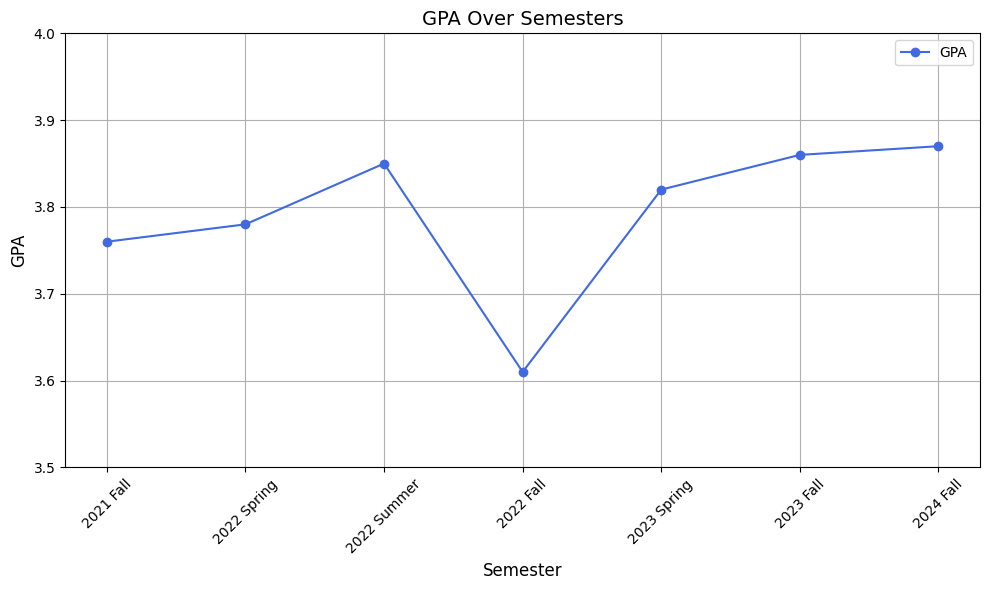

In [2]:
import matplotlib.pyplot as plt

# 学期与对应绩点
semesters = [
    "2021 Fall", "2022 Spring", "2022 Summer", "2022 Fall", 
    "2023 Spring", "2023 Fall",  "2024 Fall"
]
gpas = [3.76, 3.78, 3.85, 3.61, 3.82, 3.86, 3.87]

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(semesters, gpas, marker='o', linestyle='-', color='royalblue', label='GPA')
plt.title("GPA Over Semesters", fontsize=14)
plt.xlabel("Semester", fontsize=12)
plt.ylabel("GPA", fontsize=12)
plt.ylim(3.5, 4.0)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [1]:
import os
import shutil
import json
from glob import glob
from PIL import Image
import face_recognition
import numpy as np
import piexif
from datetime import datetime
from geopy.geocoders import Nominatim
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import spacy
from spacy.cli import download

PHOTO_DIR = "photos/"
SORTED_DIR = "sorted_photos/"
ENCODINGS_FILE = "face_encodings.json"
# 全局变量
processor = None
model = None
nlp = None

# os.makedirs(SORTED_DIR, exist_ok=True)

# ==========================
# 🌟 加载已有的人脸数据（JSON 文件）
# ==========================
def load_encodings():
    global next_label_id
    if not os.path.exists(ENCODINGS_FILE):
        print("📂 没有检测到现有的人脸数据库，初始化为空。")
        return {}, [], []

    with open(ENCODINGS_FILE, 'r') as f:
        data = json.load(f)
    
    known_face_dict = {}  # {label: encoding (np array)}
    known_face_encodings = []
    known_face_labels = []

    for label, encoding_list in data.items():
        label_int = int(label)
        encoding_array = np.array(encoding_list)
        known_face_dict[label_int] = encoding_array
        known_face_encodings.append(encoding_array)
        known_face_labels.append(label_int)
    
    next_label_id = max(known_face_dict.keys(), default=0) + 1
    print(f"✅ 成功加载 {len(known_face_dict)} 个已知人物数据。")
    return known_face_dict, known_face_encodings, known_face_labels




# ==========================
# 🌟 保存人脸编码到 JSON
# ==========================
def save_encodings(known_face_dict):
    data_to_save = {}
    for label, encoding_array in known_face_dict.items():
        data_to_save[label] = encoding_array.tolist()  # 转成 JSON 可保存的 list
    
    with open(ENCODINGS_FILE, 'w') as f:
        json.dump(data_to_save, f)
    
    print(f"💾 已保存 {len(data_to_save)} 个人物的编码数据到 {ENCODINGS_FILE}")
    
    

# 初始化函数
def init_blip_and_spacy():
    global processor, model, nlp  # 引用全局变量
    try:
        print("正在加载 BLIP 模型和处理器...")
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        print("BLIP 模型和处理器加载完成！")
    except Exception as e:
        print(f"加载 BLIP 模型时出错: {e}")
        processor, model = None, None

    try:
        print("正在检测和加载 SpaCy 英文模型...")
        download("en_core_web_sm")  # 只下载一次
        nlp = spacy.load("en_core_web_sm")
        print("SpaCy 英文模型加载完成！")
    except Exception as e:
        print(f"加载 SpaCy 模型时出错: {e}")
        nlp = None


# ==========================
# 🌟 处理单张图片
# ==========================
def process_new_photo(photo_path):
    global next_label_id
    try:
        # 1. 打开并转换图片
        with Image.open(photo_path) as img:
            img = img.convert("RGB")
            image_array = np.array(img)
        
        # 2. 人脸识别
        encodings = face_recognition.face_encodings(image_array,model='large')

        if not encodings:
            print(f"⚠️ 图片 {photo_path} 不包含人脸，跳过处理。")
            return
        
        print(f"✅ 识别到 {len(encodings)} 张人脸，开始分类...")

        for encoding in encodings:
            if len(known_face_encodings) == 0:
                # 没有人脸数据，直接新建人物
                person_label = next_label_id
                next_label_id += 1

                known_face_dict[person_label] = encoding
                known_face_encodings.append(encoding)
                known_face_labels.append(person_label)
                print(f"🆕 未检测到已有人物，新建人物 {person_label}")

            else:
                # 比较与已知人脸的相似度
                distances = face_recognition.face_distance(known_face_encodings, encoding)
                min_distance = np.min(distances)
                best_match_index = np.argmin(distances)

                if min_distance < 0.4:  # 阈值可以调整
                    person_label = known_face_labels[best_match_index]
                    # print(f"👌 匹配到人物 {person_label}，距离为 {min_distance:.2f}")
                else:
                    # 新人物
                    person_label = next_label_id
                    next_label_id += 1

                    known_face_dict[person_label] = encoding
                    known_face_encodings.append(encoding)
                    known_face_labels.append(person_label)
                    # print(f"🆕 新建人物 {person_label}，距离为 {min_distance:.2f}")
            
            # 保存照片到分类目录
            person_folder = os.path.join(SORTED_DIR, f"人物{person_label}")
            os.makedirs(person_folder, exist_ok=True)
            shutil.copy(photo_path, person_folder)
        
        # 处理完图片，保存最新的 encodings
        save_encodings(known_face_dict)
        return person_label

    except Exception as e:
        print(f"❌ 处理 {photo_path} 时出错: {e}")

def get_decimal_from_dms(dms, ref):
    """Convert GPS coordinates in DMS to decimal format."""
    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1]
    seconds = dms[2][0] / dms[2][1]

    decimal = degrees + (minutes / 60.0) + (seconds / 3600.0)

    if ref in ['S', 'W']:
        decimal = -decimal
    return decimal

def reverse_geocode(lat, lon):
    """Use geopy to reverse geocode latitude and longitude to address."""
    geolocator = Nominatim(user_agent="photo_metadata_app")
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, language='en')
        if location:
            return location.address
        else:
            return "Address not found"
    except Exception as e:
        return f"Error retrieving address: {e}"

def extract_exif_data(image_path):
    # 打开图片文件
    img = Image.open(image_path)

    # 获取 EXIF 信息
    exif_data = img._getexif()

    # 提取拍摄时间
    timestamp = None
    if exif_data and 36867 in exif_data:
        timestamp = exif_data[36867]  # DateTimeOriginal
        timestamp = datetime.strptime(timestamp, '%Y:%m:%d %H:%M:%S')

    # 使用 piexif 加载更详细的 EXIF 数据
    exif_dict = piexif.load(img.info['exif']) if 'exif' in img.info else None

    # 提取相机/设备信息
    camera_model = None
    if exif_dict:
        model = exif_dict['0th'].get(piexif.ImageIFD.Model, None)
        make = exif_dict['0th'].get(piexif.ImageIFD.Make, None)

        camera_model = ""
        if make:
            camera_model += make.decode('utf-8') + " "
        if model:
            camera_model += model.decode('utf-8')

    # 提取 GPS 信息
    gps_info = exif_dict.get('GPS', None) if exif_dict else None
    latitude = longitude = None
    address = None
    if gps_info:
        gps_latitude = gps_info.get(piexif.GPSIFD.GPSLatitude)
        gps_latitude_ref = gps_info.get(piexif.GPSIFD.GPSLatitudeRef).decode('utf-8')
        gps_longitude = gps_info.get(piexif.GPSIFD.GPSLongitude)
        gps_longitude_ref = gps_info.get(piexif.GPSIFD.GPSLongitudeRef).decode('utf-8')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            latitude = get_decimal_from_dms(gps_latitude, gps_latitude_ref)
            longitude = get_decimal_from_dms(gps_longitude, gps_longitude_ref)

            # 反向地理编码获取地址
            address = reverse_geocode(latitude, longitude)

    # 返回提取的信息
    return {
        'Timestamp': timestamp,
        'Latitude': latitude,
        'Longitude': longitude,
        'Address': address,
        'Camera/Device': camera_model
    }

# 生成图片描述
def generate_caption(image_path):
    try:
        raw_image = Image.open(image_path).convert('RGB')
        inputs = processor(raw_image, return_tensors="pt")
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Caption generation error for {image_path}: {e}")
        return "No description available."
    
def extract_noun_tags(text):
    """
    提取英文文本中的关键词（名词和专有名词）

    参数:
        text (str): 输入的英文文本

    返回:
        tags (list): 去重且小写处理后的关键词列表
    """
    if not text:
        return []

    # 分词 & 词性标注
    doc = nlp(text)

    # 只保留名词（NOUN）和专有名词（PROPN）
    tags = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]

    # 去重 & 小写（可根据需求取消小写处理）
    tags = list(set(tag.lower() for tag in tags))
    
    print(f"Image event tags: {tags}")

    return tags


# 处理图片
def process_images(img_path):
    # 提取元信息
    metadata = extract_exif_data(img_path)
    
    # 生成描述
    caption = generate_caption(img_path)

    #Aoto-tagging
    tags = extract_noun_tags(caption)
    
    #人脸识别 
    person_label = process_new_photo(img_path)
    
    # ✅ 平铺 JSON 格式
    photo_info = {
        'Timestamp': metadata.get('Timestamp'),
        'Latitude': metadata.get('Latitude'),
        'Longitude': metadata.get('Longitude'),
        'Address': metadata.get('Address'),
        'Camera/Device': metadata.get('Camera/Device'),
        'Caption': caption,
        'AutoTags': tags,
        'PersonLabel': person_label
    }
    
    print(f"Processed {img_path}: {caption} @ {photo_info.get('Address')} on {photo_info.get('Timestamp')}") 
    
    return photo_info

In [11]:
# ==========================
# 🌟 初始化已知人脸数据
# ==========================
known_face_dict, known_face_encodings, known_face_labels = load_encodings()
# 调用初始化函数
# 调用初始化（只执行一次）
init_blip_and_spacy()


✅ 成功加载 11 个已知人物数据。
正在加载 BLIP 模型和处理器...
BLIP 模型和处理器加载完成！
正在检测和加载 SpaCy 英文模型...
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
SpaCy 英文模型加载完成！


In [12]:

process_images("photos/15.jpg")

Image event tags: ['man', 'fountain', 'front']
✅ 识别到 7 张人脸，开始分类...
💾 已保存 11 个人物的编码数据到 face_encodings.json
Processed photos/15.jpg: a man standing in front of a fountain @ Window of the World, Shennan Boulevard, Huaxia Jie, Shahe Sub-district, Nanshan District, Shenzhen, Guangdong Province, 518000, China on 2025-01-31 18:03:58


{'Timestamp': datetime.datetime(2025, 1, 31, 18, 3, 58),
 'Latitude': 22.536686111111113,
 'Longitude': 113.97063611111112,
 'Address': 'Window of the World, Shennan Boulevard, Huaxia Jie, Shahe Sub-district, Nanshan District, Shenzhen, Guangdong Province, 518000, China',
 'Camera/Device': 'vivo iQOO Neo8 Pro',
 'Caption': 'a man standing in front of a fountain',
 'AutoTags': ['man', 'fountain', 'front'],
 'PersonLabel': 6}

In [ ]:
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import shutil
import os
from datetime import datetime


app = FastAPI()

@app.on_event("startup")
async def startup_event():
    global known_face_dict, known_face_encodings, known_face_labels
    known_face_dict, known_face_encodings, known_face_labels = load_encodings()
    init_blip_and_spacy()

# 上传图片接口
@app.post("/process_image")
async def process_image(file: UploadFile = File(...)):
    try:        
        # 调用处理函数
        result = process_images(file)

        # 返回 JSON
        return JSONResponse(content=result)

    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

In [25]:
import requests

url = "http://localhost:8123/process_image"
files = {'file': open('photos/25.jpg', 'rb')}
response = requests.post(url, files=files)
print(response.json())

{'Timestamp': '2025-05-25 01:01:41', 'Latitude': None, 'Longitude': None, 'Address': None, 'Camera/Device': 'Xiaomi 23013RK75C', 'Caption': 'a computer monitor', 'AutoTags': ['monitor', 'computer'], 'PersonLabel': []}


In [2]:
# video_generator.py
import os
import gc
import random
import json
import chardet
from PIL import Image, ImageFilter
from moviepy.editor import (
    ImageSequenceClip, AudioFileClip, CompositeVideoClip,
    concatenate_videoclips, VideoFileClip, vfx
)
from datetime import datetime
import numpy as np

def get_config():
    config_file = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'config.json')
    with open(config_file, 'rb') as f:
        encoding_result = chardet.detect(raw_data := f.read())
        encoding = encoding_result['encoding']
    return json.loads(raw_data.decode(encoding))

def transform_image(img, t, x_speed, y_speed, move_on_x, move_positive):
    original_size = img.size
    crop_width = img.width * 0.8
    crop_height = img.height * 0.8
    if move_on_x:
        left = min(x_speed * t, img.width - crop_width) if move_positive else max(img.width - crop_width - x_speed * t, 0)
        upper = (img.height - crop_height) / 2
    else:
        upper = min(y_speed * t, img.height - crop_height) if move_positive else max(img.height - crop_height - y_speed * t, 0)
        left = (img.width - crop_width) / 2
    cropped_img = img.crop((left, upper, left + crop_width, upper + crop_height))
    return cropped_img.resize(original_size)

def generate_video(image_paths: list[str]) -> str:
    current_dir = os.path.dirname(os.path.abspath(__file__))
    config = get_config()

    temp_dir = os.path.join(current_dir, 'temp')
    video_dir = os.path.join(current_dir, 'video')
    voice_path = os.path.join(current_dir, 'bgm', 'bgm.mp3')

    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(video_dir, exist_ok=True)

    fps = config['fps']
    enlarge_background = config['enlarge_background']
    duration = config['duration']

    bgm_audio = AudioFileClip(voice_path)
    clips = []

    for idx, img_path in enumerate(image_paths):
        im = Image.open(img_path)
        effect_type = random.choice([0, 1])
        if effect_type == 0:
            x_speed = (im.width - im.width * 0.8) / duration
            y_speed = 0
            move_on_x = True
            move_positive = random.choice([True, False])
        else:
            x_speed = 0
            y_speed = (im.height - im.height * 0.8) / duration
            move_on_x = False
            move_positive = random.choice([True, False])

        n_frames = int(fps * duration)
        frames_foreground = [np.array(transform_image(im, t / fps, x_speed, y_speed, move_on_x, move_positive)) for t in range(n_frames)]
        img_foreground = ImageSequenceClip(frames_foreground, fps=fps)

        img_blur = im.filter(ImageFilter.GaussianBlur(radius=30))
        if enlarge_background:
            img_blur = img_blur.resize((int(im.width * 1.1), int(im.height * 1.1)), Image.Resampling.LANCZOS)
        frames_background = [np.array(img_blur)] * n_frames
        img_background = ImageSequenceClip(frames_background, fps=fps)

        final_clip = CompositeVideoClip(
            [img_background.set_position("center"), img_foreground.set_position("center")],
            size=img_blur.size
        )

        final_clip = final_clip.set_duration(duration)
        temp_clip_path = os.path.join(temp_dir, f'temp_{idx}.mp4')
        final_clip.write_videofile(temp_clip_path, logger=None)
        clips.append(VideoFileClip(temp_clip_path))
        gc.collect()

    final_video = concatenate_videoclips(clips, method="compose")
    final_video = final_video.set_audio(bgm_audio.subclip(0, final_video.duration))
    output_path = os.path.join(video_dir, f'output_{datetime.now().strftime("%Y%m%d%H%M%S")}.mp4')
    final_video.write_videofile(output_path, logger=None)
    return output_path


In [6]:
import uvicorn
# app.py
import os
import shutil
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import FileResponse
from typing import List

app = FastAPI()

# UPLOAD_FOLDER = os.path.join(os.path.dirname(__file__), "image")
UPLOAD_FOLDER = os.path.join(os.getcwd(), "image")
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

@app.post("/generate_video/")
async def generate_video_api(files: List[UploadFile] = File(...)):
    saved_files = []

    for file in files:
        file_path = os.path.join(UPLOAD_FOLDER, file.filename)
        with open(file_path, "wb") as f:        
            content = await file.read()
            f.write(content)
        saved_files.append(file_path)

    try:
        output_video_path = generate_video(saved_files)
        return FileResponse(output_video_path, media_type="video/mp4", filename=os.path.basename(output_video_path))
    finally:
        # 清理临时文件
        for path in saved_files:
            os.remove(path)
            
    

RuntimeError: asyncio.run() cannot be called from a running event loop

In [8]:
import requests

# 接口地址（请根据需要替换 host 和 port）
url = "http://localhost:8123/generate_video/"

# 要上传的图片文件路径（替换成你自己的）
image_paths = [
    "image/output_1.png",
    "image/output_2.png",
    "image/output_3.png",
    "image/output_4.png",
    "image/output_5.png",
    "image/output_6.png",
    "img/IMG_20230909_010443.png", 
    "img/IMG_20230909_030556.png"
]

# image_paths = ["img/IMG_20230909_010443.png", "img/IMG_20230909_030556.png"]

# 构建文件列表，格式为元组列表
files = [('files', (os.path.basename(path), open(path, 'rb'), 'image/jpeg')) for path in image_paths]

# 发送 POST 请求
response = requests.post(url, files=files)

# 处理响应
if response.status_code == 200:
    output_path = "result_video.mp4"
    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"✅ 视频保存成功：{output_path}")
else:
    print(f"❌ 请求失败，状态码: {response.status_code}")
    print(response.text)
    


✅ 视频保存成功：result_video.mp4


In [48]:
import requests
import time

# 替换为你的 DashScope API Key
API_KEY = "sk-e8f3a16e76644be7a84db556d976a674"

# 1. 异步图像生成请求
import requests

def generate_image(image_url,style_index):
    url = "https://dashscope.aliyuncs.com/api/v1/services/aigc/image-generation/generation"
    headers = {
        "X-DashScope-Async": "enable",
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "wanx-style-repaint-v1",
        "input": {
            "image_url": image_url,
            "style_index": style_index
        }
    }

    response = requests.post(url, headers=headers, json=payload)
    
    if response.status_code == 200:
        task_id = response.json().get("output", {}).get("task_id")
        print(f"任务已提交，任务ID: {task_id}")
        return task_id
    else:
        print("提交失败：", response.status_code, response.text)
        return None


# 2. 根据任务 ID 查询状态
def check_task_status(task_id):
    url = f"https://dashscope.aliyuncs.com/api/v1/tasks/{task_id}"
    headers = {
        "Authorization": f"Bearer {API_KEY}"
    }

    while True:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            output = data.get("output", {})
            status = output.get("task_status")
            
            if status == "SUCCEEDED":
                result_url = output.get("results", [{}])[0].get("url")
                print("✅ 图像生成成功！")
                print("🔗 下载地址：", result_url)
                break
            else:
                print("⚠️ 任务未立即成功，任务状态：", status)
                print("任务 ID：", output.get("task_id"))
        else:
            print("❌ 请求失败：", response.status_code, response.text)
            break
        

In [49]:
# 主函数
url = "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/public/dashscope/test.png"
style_index = 0
task_id = generate_image(url, style_index)
if task_id:
    check_task_status(task_id)

任务已提交，任务ID: 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce6-9a2b15c53b0c
⚠️ 任务未立即成功，任务状态： RUNNING
任务 ID： 81888823-198a-4fbc-bce

In [40]:


if task_id:
    # check_task_status(task_id)
    url = f"https://dashscope.aliyuncs.com/api/v1/tasks/{task_id}"
    headers = {
        "Authorization": f"Bearer {API_KEY}"
    }

    # while True:
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        output = data.get("output", {})
        status = output.get("task_status")

        if status == "SUCCEEDED":
            result_url = output.get("results", [{}])[0].get("url")
            print("✅ 图像生成成功！")
            print("🔗 下载地址：", result_url)
        else:
            print("⚠️ 任务未立即成功，任务状态：", status)
            print("任务 ID：", output.get("task_id"))
    else:
        print("❌ 请求失败：", response.status_code, response.text)


✅ 图像生成成功！
🔗 下载地址： https://dashscope-result-wlcb.oss-cn-wulanchabu.aliyuncs.com/1d/78/20250525/81750fc9/20250525115648505340_style3_51g7tz0vja.jpg?Expires=1748231812&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=x9vjrWAJxNfaAZ99IJ8xRfMyax0%3D


In [5]:
def generate_image(local_image_path, style_index):
    url = "https://dashscope.aliyuncs.com/api/v1/services/aigc/image-generation/generation"
    headers = {
        "X-DashScope-Async": "enable",
        "Authorization": f"Bearer {API_KEY}",
        # Content-Type 不设置，requests 会自动处理 multipart/form-data
    }

    files = {
        "image_file": open(local_image_path, "rb"),  # 这里的字段名请确认接口文档，假设是 image_file
    }

    data = {
        "model": "wanx-style-repaint-v1",
        "input": {
            "style_index": style_index
        }
    }

    # 注意这里需要同时传 files 和 data（json要转换成字符串）
    # 有些接口要求把json参数放到普通字段里，比如 'payload' 或 'data'，具体看接口文档
    # 这里假设接口要求放到 'payload' 字段，或者直接放在普通 form 字段里

    # 如果接口要求json字符串字段叫 payload，示例：
    payload = {
        "payload": json.dumps(data)
    }

    response = requests.post(url, headers=headers, files=files, data=payload)

    if response.status_code == 200:
        task_id = response.json().get("output", {}).get("task_id")
        print(f"任务已提交，任务ID: {task_id}")
        return task_id
    else:
        print("提交失败：", response.status_code, response.text)
        return None



# 2. 根据任务 ID 查询状态
def check_task_status(task_id):
    url = f"https://dashscope.aliyuncs.com/api/v1/tasks/{task_id}"
    headers = {
        "Authorization": f"Bearer {API_KEY}"
    }

    while True:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            output = data.get("output", {})
            status = output.get("task_status")

            if status == "SUCCEEDED":
                result_url = output.get("results", [{}])[0].get("url")
                print("✅ 图像生成成功！")
                print("🔗 下载地址：", result_url)
                return result_url
                break
            else:
                print("⚠️ 任务未立即成功，任务状态：", status)
                print("任务 ID：", output.get("task_id"))
        else:
            print("❌ 请求失败：", response.status_code, response.text)
            return None
            break

In [63]:
import requests
# url = "http://localhost:8123/generate_capetion/"
url = "http://localhost:8123/auto_tag/"
# url = "http://localhost:8123/extract_exif/"
# url = "http://localhost:8123/face_recognition/"
# url = "http://localhost:8123/process_image/"
files = {'file': open('photos/25.jpg', 'rb')}
response = requests.post(url, files=files)
print(response.json())

{'tags': ['computer', 'monitor']}


In [7]:
import requests

# 替换为你本地或线上 FastAPI 服务的地址
url = "http://localhost:8123/style_transfer/"

# 要使用的风格编号
style_index = 0  # 可以修改为你想测试的风格编号

# 打开图片并构造 multipart/form-data 请求
# with open(image_path, "rb") as image_file:
#     files = {
#         "file": (image_path, image_file, "image/jpeg")
#     }
files = {'file': open('photos/16.jpg', 'rb')}
data = {
    "style_index": style_index
}

response = requests.post(url, files=files, data=data)

# 打印响应结果
if response.status_code == 200:
    print("风格化任务提交成功：")
    print(response.json())
else:
    print(f"提交失败，状态码：{response.status_code}")
    print("错误信息：", response.text)



风格化任务提交成功：
{'task_id': '46733e90-ef4d-4a9b-b5dc-15082cd3cd88', 'result_url': 'https://dashscope-result-wlcb.oss-cn-wulanchabu.aliyuncs.com/1d/06/20250525/81750fc9/20250525160537191180_style0_q0laxient5.jpg?Expires=1748246743&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=nwrlcZ6tRjivk5D7VD%2FJwI5wxyg%3D'}


In [3]:
import requests

url = "https://www.picgo.net/api/1/upload"
X_API_Key = "chv_S0w6G_50f4a3a43d317348a22ffba85e7caa319b0ebee0afe182d29bc18d70827b6b7e88b2fdf15a6b1a8f6a1b7e28224368473ee12618a440de7269ee091221d230a2"  # 替换为你的实际key
image_path = "photos/25.jpg"  # 替换为你本地的图片路径

headers = {
    "X-API-Key": X_API_Key,
}

files = {
    "source": open(image_path, "rb"),
}

response = requests.post(url, headers=headers, files=files)

# 打印响应结果
if response.ok:
    print("上传成功！")
    # 提取高清图像的URL
    response_json = response.json()
    image_url = response_json['image']['url']
    print(image_url)
else:
    print("上传失败！")
    print(response.status_code)
    print(response.text)


上传失败！
400
{"status_code":400,"error":{"message":"Duplicated upload","code":101},"status_txt":"Bad Request"}
